C:\Users\hp\AppData\Local\Temp\ipykernel_6952\3136565085.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[condition_columns] = df[condition_columns].applymap(lambda x: 1 if str(x).strip().lower() in ["yes", "1", "true"] else 0)


Epoch 1/20, Loss: 69.714992
Epoch 2/20, Loss: 21.676844
Epoch 3/20, Loss: 13.904543
Epoch 4/20, Loss: 12.514398
Epoch 5/20, Loss: 11.214165
Epoch 6/20, Loss: 10.463312
Epoch 7/20, Loss: 9.612863
Epoch 8/20, Loss: 9.463587
Epoch 9/20, Loss: 9.059246
Epoch 10/20, Loss: 9.068037
Epoch 11/20, Loss: 9.089166
Epoch 12/20, Loss: 8.865161
Epoch 13/20, Loss: 8.977364
Epoch 14/20, Loss: 9.134089
Epoch 15/20, Loss: 9.171653
Epoch 16/20, Loss: 9.248043
Epoch 17/20, Loss: 9.309088
Epoch 18/20, Loss: 9.673072
Epoch 19/20, Loss: 9.512491
Epoch 20/20, Loss: 9.350298
Epoch 1/20, Loss: 29.530220
Epoch 2/20, Loss: 10.355756
Epoch 3/20, Loss: 9.423891
Epoch 4/20, Loss: 9.059593
Epoch 5/20, Loss: 8.718587
Epoch 6/20, Loss: 9.050529
Epoch 7/20, Loss: 8.844004
Epoch 8/20, Loss: 8.457669
Epoch 9/20, Loss: 8.382594
Epoch 10/20, Loss: 7.628492
Epoch 11/20, Loss: 7.542578
Epoch 12/20, Loss: 7.451040
Epoch 13/20, Loss: 7.396304
Epoch 14/20, Loss: 7.740430
Epoch 15/20, Loss: 6.918175
Epoch 16/20, Loss: 6.886579
Ep

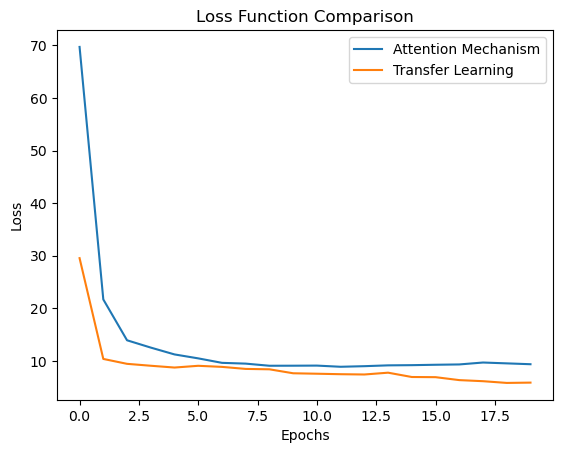

Attention Mechanism - MAE: 8.16, Error%: 11.22%
Transfer Learning - MAE: 9.64, Error%: 13.42%


In [3]:
#9 CNN WITH SELF-ATTENTION MECHANISM OUTPERFORMING TRANSFER MODEL (TRAINING ON GROND TRUTH)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import os
from torchvision import transforms
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, precision_recall_fscore_support
import pandas as pd

# Dataset paths
TEXT_DATASET_PATH = "C:/Users/hp/Desktop/DatasetVideoFiles/predata/0_subject"
GROUND_TRUTH_PATH = "C:/Users/hp/Desktop/DatasetVideoFiles/predata/PPG-BP dataset.xlsx"

# Load ground truth HR data
df = pd.read_excel(GROUND_TRUTH_PATH, sheet_name="cardiovascular dataset")
df.columns = ["Num", "subject_ID", "Sex", "Age", "Height(cm)", "Weight(kg)",
              "Systolic_BP", "Diastolic_BP", "Heart_Rate(bpm)", "BMI",
              "Hypertension", "Diabetes", "cerebral infarction", "cerebrovascular disease"]
df = df.iloc[1:].reset_index(drop=True)

# Convert medical conditions to binary
condition_columns = ["Hypertension", "Diabetes", "cerebral infarction", "cerebrovascular disease"]
df[condition_columns] = df[condition_columns].applymap(lambda x: 1 if str(x).strip().lower() in ["yes", "1", "true"] else 0)
df[condition_columns] = df[condition_columns].fillna(0).astype(int)
ground_truth_hr = df["Heart_Rate(bpm)"].astype(float).values

# Bandpass filter to remove noise
def bandpass_filter(signal, lowcut=0.5, highcut=3.0, fs=100, order=3):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Load PPG signals and HR labels
def load_ppg_signals(folder):
    signals, hr_values, conditions = [], [], []
    file_list = sorted(os.listdir(folder))
    num_hr_values = len(ground_truth_hr)

    for i, file in enumerate(file_list):
        if file.endswith(".txt"):
            if i >= num_hr_values:
                break
            
            filepath = os.path.join(folder, file)
            data = np.loadtxt(filepath)
            if len(data) >= 2100:
                data = bandpass_filter(data[:1800])
                data = (data - np.mean(data)) / np.std(data)  # Normalize

                segments = np.split(data, 3)  # Split into 3 segments
                signals.extend(segments)
                hr_values.extend([ground_truth_hr[i]] * 3)
                conditions.extend([df.iloc[i][condition_columns].values] * 3)

    return np.array(signals).reshape(-1, 1, 600), np.array(hr_values), np.array(conditions, dtype=np.float32)

ppg_signals, hr_labels, condition_labels = load_ppg_signals(TEXT_DATASET_PATH)

# Train-test split
train_ppg, test_ppg, train_hr, test_hr, train_conditions, test_conditions = train_test_split(
    ppg_signals, hr_labels, condition_labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_ppg, test_ppg = map(lambda x: torch.tensor(x, dtype=torch.float32), (train_ppg, test_ppg))
train_hr, test_hr = map(lambda x: torch.tensor(x, dtype=torch.float32).view(-1, 1), (train_hr, test_hr))
train_conditions, test_conditions = map(lambda x: torch.tensor(x, dtype=torch.float32), (train_conditions, test_conditions))

train_loader = data.DataLoader(list(zip(train_ppg, train_hr, train_conditions)), batch_size=16, shuffle=True)
test_loader = data.DataLoader(list(zip(test_ppg, test_hr, test_conditions)), batch_size=16, shuffle=False)



# Use previously loaded dataset variables
train_loader = train_loader 
test_loader = test_loader  

# Define CNN with Attention Mechanism (Squeeze-and-Excitation Block)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch, channels, _ = x.shape
        y = self.global_avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1)
        return x * y

class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.se1 = SEBlock(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.se2 = SEBlock(128)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_hr = nn.Linear(128, 1)
        self.fc_cond = nn.Linear(128, 4)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.se1(x)
        x = torch.relu(self.conv3(x))
        x = self.se2(x)
        x = self.global_avg_pool(x).squeeze(-1)
        hr_output = self.fc_hr(x)
        cond_output = torch.softmax(self.fc_cond(x), dim=1)
        return hr_output, cond_output

# Define CNN with Transfer Learning (Using ResNet as Feature Extractor)
class CNNWithTransferLearning(nn.Module):
    def __init__(self):
        super(CNNWithTransferLearning, self).__init__()
        
        # Load ResNet18 model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Modify first conv layer to accept 1-channel input instead of 3-channel RGB
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify fully connected layer for the new task
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 128)

        # Output layers
        self.fc_hr = nn.Linear(128, 1)
        self.fc_cond = nn.Linear(128, 4)

    def forward(self, x):
        # Ensure input is 4D [batch_size, channels, height, width]
        x = x.unsqueeze(1)  # Convert [batch_size, 1, seq_length] → [batch_size, 1, seq_length, 1]
        x = torch.nn.functional.interpolate(x, size=(64, 64), mode="bilinear", align_corners=False)  # Resize to 64x64
        
        x = self.resnet(x)  # Pass through ResNet
        
        hr_output = self.fc_hr(x)  # Predict HR
        cond_output = torch.softmax(self.fc_cond(x), dim=1)  # Predict condition
        
        return hr_output, cond_output




# Define training function
def train_model(model, train_loader, num_epochs=20, lr=0.001):
    criterion_hr = nn.HuberLoss()
    criterion_cond = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for signals, hr_values, cond_values in train_loader:
            optimizer.zero_grad()
            hr_pred, cond_pred = model(signals)
            loss_hr = criterion_hr(hr_pred, hr_values)
            loss_cond = criterion_cond(cond_pred, torch.argmax(cond_values, dim=1))
            loss = loss_hr + loss_cond
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss_history.append(running_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.6f}")
    
    return loss_history

# Function to evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    hr_preds, hr_truths, cond_preds, cond_truths = [], [], [], []
    with torch.no_grad():
        for signals, hr_values, cond_values in test_loader:
            hr_pred, cond_pred = model(signals)
            hr_preds.extend(hr_pred.numpy())
            hr_truths.extend(hr_values.numpy())
            cond_preds.extend(torch.argmax(cond_pred, dim=1).numpy())
            cond_truths.extend(torch.argmax(cond_values, dim=1).numpy())
    
    mae = mean_absolute_error(hr_truths, hr_preds)
    error_percentage = np.mean(np.abs((np.array(hr_preds) - np.array(hr_truths)) / np.array(hr_truths))) * 100
    return mae, error_percentage

# Train both models

# Train and evaluate CNN with Attention
model_attention = CNNWithAttention()
loss_attention = train_model(model_attention, train_loader)
mae_attention, error_attention = evaluate_model(model_attention, test_loader)

# Train and evaluate CNN with Transfer Learning
model_transfer = CNNWithTransferLearning()
loss_transfer = train_model(model_transfer, train_loader)
mae_transfer, error_transfer = evaluate_model(model_transfer, test_loader)

# Plot loss comparison
plt.plot(loss_attention, label='Attention Mechanism')
plt.plot(loss_transfer, label='Transfer Learning')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Function Comparison")
plt.show()

# Print results
print(f"Attention Mechanism - MAE: {mae_attention:.2f}, Error%: {error_attention:.2f}%")
print(f"Transfer Learning - MAE: {mae_transfer:.2f}, Error%: {error_transfer:.2f}%")


In [5]:
#9.2 SAVING MODEL
torch.save(model.state_dict(), 'model_weights.pth')


In [7]:
# 9.3 SELECTION OF CNN WITH SELF ATTENTIONMECHANSISM (TRAINING + VALIDATION ON VIDEO DATASET) initially for 20 epochs
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import mean_absolute_error

# ======== Video Dataset ============
class VideoPPGDataset(Dataset):
    def __init__(self, video_dir, label_dict, max_frames=300):
        self.video_dir = video_dir
        self.label_dict = label_dict
        self.video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4') or f.endswith('.avi')]
        self.max_frames = max_frames

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        file = self.video_files[idx]
        filepath = os.path.join(self.video_dir, file)
        cap = cv2.VideoCapture(filepath)

        green_signal = []
        x_motion = []

        prev_frame = None
        count = 0
        while cap.isOpened() and count < self.max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            roi = frame[100:200, 150:250]  # Adjust ROI
            green = roi[:, :, 1].mean()
            green_signal.append(green)
    
            if prev_frame is not None:
                motion = np.abs(roi.astype(np.float32) - prev_frame.astype(np.float32)).mean()
                x_motion.append(motion)
            else:
                x_motion.append(0.0)
    
            prev_frame = roi
            count += 1
    
        cap.release()

        # Convert to numpy and pad/truncate
        green_signal = np.array(green_signal)
        x_motion = np.array(x_motion)
    
        if len(green_signal) < self.max_frames:
            pad_len = self.max_frames - len(green_signal)
            green_signal = np.pad(green_signal, (0, pad_len), mode='edge')
            x_motion = np.pad(x_motion, (0, pad_len), mode='edge')
        else:
            green_signal = green_signal[:self.max_frames]
            x_motion = x_motion[:self.max_frames]

        # Normalize
        green_signal = (green_signal - np.mean(green_signal)) / (np.std(green_signal) + 1e-8)
        x_motion = (x_motion - np.mean(x_motion)) / (np.std(x_motion) + 1e-8)
    
        sample = np.stack([green_signal, x_motion], axis=0)  # [2, max_frames]
        label = float(self.label_dict.get(os.path.splitext(file)[0], 0))
    
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), file


# ======== Hybrid HR Estimation Model ============
class ConvFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)

    def forward(self, x):
        q, k, v = self.query(x), self.key(x), self.value(x)
        scores = torch.bmm(q, k.transpose(1, 2)) / (x.size(-1) ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        return torch.bmm(attn_weights, v)


# ======== CNN + Self-Attention Model ============
class CNNBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x):  # x: [B, 2, T]
        return self.conv(x)  # [B, 128, T]


class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.key = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.value = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)

    def forward(self, x):  # x: [B, C, T]
        Q = self.query(x).permute(0, 2, 1)  # [B, T, C]
        K = self.key(x)                     # [B, C, T]
        V = self.value(x).permute(0, 2, 1)  # [B, T, C]

        scores = torch.bmm(Q, K) / (x.size(1) ** 0.5)  # [B, T, T]
        attn_weights = F.softmax(scores, dim=-1)
        out = torch.bmm(attn_weights, V)  # [B, T, C]
        return out.permute(0, 2, 1)  # [B, C, T]


class HRPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = CNNBlock()
        self.attn = SelfAttention(embed_dim=128)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.cnn(x)        # [B, 128, T]
        x = self.attn(x)       # [B, 128, T]
        x = self.global_pool(x).squeeze(-1)  # [B, 128]
        return self.fc(x).squeeze(1)         # [B]


# ======== Train Model ============
def train_model(model, train_loader, val_loader, device, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, _ in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val, _ in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                pred = model(x_val)
                val_loss += criterion(pred, y_val).item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


# ======== Evaluate on All Videos ============
def evaluate_all_videos(model, dataset, device):
    model.eval()
    errors = []
    predictions = []
    ground_truths = []
    filenames = []

    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        for inputs, targets, file in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).cpu().numpy()
            targets = targets.cpu().numpy()

            predictions.append(outputs[0])
            ground_truths.append(targets[0])
            filenames.append(file[0])
            errors.append(abs(outputs[0] - targets[0]))

    mae = np.mean(errors)
    error_percent = np.mean([abs(p - t) / t * 100 for p, t in zip(predictions, ground_truths)])

    print("\n===== Per-Video Heart Rate Prediction =====")
    for f, pred, true, err in zip(filenames, predictions, ground_truths, errors):
        print(f"{f}: Predicted = {pred:.2f} bpm, Actual = {true:.2f} bpm, Error = {err:.2f} bpm")

    print(f"\nOverall MAE across {len(errors)} videos: {mae:.2f} bpm")
    print(f"Average Error Percentage: {error_percent:.2f}%")


# ======== Prepare Dataset ============
def load_label_dict(excel_path):
    df = pd.read_excel(excel_path)
    return {
        str(row['FileName']).strip(): float(row['Heart Rate (bpm)'])
        for _, row in df.iterrows()
    }


if __name__ == '__main__':
    video_dir = "C:/Users/hp/Desktop/DatasetVideoFiles/DatasetVideoFiles"
    label_file = "C:/Users/hp/Desktop/DatasetVideoFiles/ProjectDatasetReadings.xlsx"

    label_dict = load_label_dict(label_file)
    dataset = VideoPPGDataset(video_dir, label_dict)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    model = HRPredictionModel()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_model(model, train_loader, val_loader, device)

    # Evaluate on all 51 videos
    evaluate_all_videos(model, dataset, device)


Epoch 1/20, Train Loss: 90.1122, Val Loss: 86.0710
Epoch 2/20, Train Loss: 86.9761, Val Loss: 81.2250
Epoch 3/20, Train Loss: 70.6141, Val Loss: 49.1150
Epoch 4/20, Train Loss: 35.5777, Val Loss: 17.7680
Epoch 5/20, Train Loss: 34.2710, Val Loss: 14.1638
Epoch 6/20, Train Loss: 31.2397, Val Loss: 16.1592
Epoch 7/20, Train Loss: 29.1933, Val Loss: 14.2686
Epoch 8/20, Train Loss: 25.3508, Val Loss: 19.1232
Epoch 9/20, Train Loss: 25.0203, Val Loss: 17.2078
Epoch 10/20, Train Loss: 22.6284, Val Loss: 15.8602
Epoch 11/20, Train Loss: 22.3338, Val Loss: 17.3630
Epoch 12/20, Train Loss: 22.2374, Val Loss: 22.7279
Epoch 13/20, Train Loss: 20.1676, Val Loss: 20.4113
Epoch 14/20, Train Loss: 21.2367, Val Loss: 15.4282
Epoch 15/20, Train Loss: 19.8527, Val Loss: 18.7456
Epoch 16/20, Train Loss: 20.9442, Val Loss: 15.0973
Epoch 17/20, Train Loss: 20.3526, Val Loss: 14.4867
Epoch 18/20, Train Loss: 19.5386, Val Loss: 19.2208
Epoch 19/20, Train Loss: 18.4175, Val Loss: 15.0258
Epoch 20/20, Train Lo

In [15]:
# cnn with hyper parameter tuning (b. epochs=50, lr=0.005, etc.)
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import mean_absolute_error

# ======== Video Dataset ============
class VideoPPGDataset(Dataset):
    def __init__(self, video_dir, label_dict, max_frames=600):  # Increased max frames
        self.video_dir = video_dir
        self.label_dict = label_dict
        self.video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4') or f.endswith('.avi')]
        self.max_frames = max_frames

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        file = self.video_files[idx]
        filepath = os.path.join(self.video_dir, file)
        cap = cv2.VideoCapture(filepath)

        green_signal = []
        x_motion = []

        prev_frame = None
        count = 0
        while cap.isOpened() and count < self.max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            roi = frame[100:200, 150:250]  # Adjust ROI
            green = roi[:, :, 1].mean()
            green_signal.append(green)
    
            if prev_frame is not None:
                motion = np.abs(roi.astype(np.float32) - prev_frame.astype(np.float32)).mean()
                x_motion.append(motion)
            else:
                x_motion.append(0.0)
    
            prev_frame = roi
            count += 1
    
        cap.release()

        # Convert to numpy and pad/truncate
        green_signal = np.array(green_signal)
        x_motion = np.array(x_motion)
    
        if len(green_signal) < self.max_frames:
            pad_len = self.max_frames - len(green_signal)
            green_signal = np.pad(green_signal, (0, pad_len), mode='edge')
            x_motion = np.pad(x_motion, (0, pad_len), mode='edge')
        else:
            green_signal = green_signal[:self.max_frames]
            x_motion = x_motion[:self.max_frames]

        # Normalize
        green_signal = (green_signal - np.mean(green_signal)) / (np.std(green_signal) + 1e-8)
        x_motion = (x_motion - np.mean(x_motion)) / (np.std(x_motion) + 1e-8)
    
        sample = np.stack([green_signal, x_motion], axis=0)  # [2, max_frames]
        label = float(self.label_dict.get(os.path.splitext(file)[0], 0))
    
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), file


# ======== Hybrid HR Estimation Model ============
class ConvFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)

    def forward(self, x):
        q, k, v = self.query(x), self.key(x), self.value(x)
        scores = torch.bmm(q, k.transpose(1, 2)) / (x.size(-1) ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        return torch.bmm(attn_weights, v)


# ======== CNN + Self-Attention Model ============
class CNNBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x):  # x: [B, 2, T]
        return self.conv(x)  # [B, 128, T]


class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.key = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.value = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)

    def forward(self, x):  # x: [B, C, T]
        Q = self.query(x).permute(0, 2, 1)  # [B, T, C]
        K = self.key(x)                     # [B, C, T]
        V = self.value(x).permute(0, 2, 1)  # [B, T, C]

        scores = torch.bmm(Q, K) / (x.size(1) ** 0.5)  # [B, T, T]
        attn_weights = F.softmax(scores, dim=-1)
        out = torch.bmm(attn_weights, V)  # [B, T, C]
        return out.permute(0, 2, 1)  # [B, C, T]


class HRPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = CNNBlock()
        self.attn = SelfAttention(embed_dim=128)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.cnn(x)        # [B, 128, T]
        x = self.attn(x)       # [B, 128, T]
        x = self.global_pool(x).squeeze(-1)  # [B, 128]
        return self.fc(x).squeeze(1)         # [B]


# ======== Train Model ============
def train_model(model, train_loader, val_loader, device, epochs=50): 
    optimizer = optim.Adam(model.parameters(), lr=0.0005)  
    criterion = nn.HuberLoss()  # Changed to Huber Loss

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, _ in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val, _ in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                pred = model(x_val)
                val_loss += criterion(pred, y_val).item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


# ======== Evaluate on All Videos ============
def evaluate_all_videos(model, dataset, device):
    model.eval()
    errors = []
    predictions = []
    ground_truths = []
    filenames = []

    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        for inputs, targets, file in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).cpu().numpy()
            targets = targets.cpu().numpy()

            predictions.append(outputs[0])
            ground_truths.append(targets[0])
            filenames.append(file[0])
            errors.append(abs(outputs[0] - targets[0]))

    mae = np.mean(errors)
    error_percent = np.mean([abs(p - t) / t * 100 for p, t in zip(predictions, ground_truths)])

    print("\n===== Per-Video Heart Rate Prediction =====")
    for f, pred, true, err in zip(filenames, predictions, ground_truths, errors):
        print(f"{f}: Predicted = {pred:.2f} bpm, Actual = {true:.2f} bpm, Error = {err:.2f} bpm")

    print(f"\nOverall MAE across {len(errors)} videos: {mae:.2f} bpm")
    print(f"Average Error Percentage: {error_percent:.2f}%")


# ======== Prepare Dataset ============
def load_label_dict(excel_path):
    df = pd.read_excel(excel_path)
    return {
        str(row['FileName']).strip(): float(row['Heart Rate (bpm)'])
        for _, row in df.iterrows()
    }


if __name__ == '__main__':
    video_dir = "C:/Users/hp/Desktop/DatasetVideoFiles/DatasetVideoFiles"
    label_file = "C:/Users/hp/Desktop/DatasetVideoFiles/ProjectDatasetReadings.xlsx"

    label_dict = load_label_dict(label_file)
    dataset = VideoPPGDataset(video_dir, label_dict)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjusted batch size
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)  # Adjusted batch size

    model = HRPredictionModel()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_model(model, train_loader, val_loader, device)

    # Evaluate on all 51 videos
    evaluate_all_videos(model, dataset, device)


Epoch 1/50, Train Loss: 90.2667, Val Loss: 84.0524
Epoch 2/50, Train Loss: 91.3387, Val Loss: 83.5277
Epoch 3/50, Train Loss: 89.9515, Val Loss: 81.9978
Epoch 4/50, Train Loss: 85.5244, Val Loss: 74.5696
Epoch 5/50, Train Loss: 70.9318, Val Loss: 54.6711
Epoch 6/50, Train Loss: 48.1323, Val Loss: 30.1307
Epoch 7/50, Train Loss: 37.2308, Val Loss: 22.2709
Epoch 8/50, Train Loss: 34.2653, Val Loss: 19.4324
Epoch 9/50, Train Loss: 26.9141, Val Loss: 14.9555
Epoch 10/50, Train Loss: 23.3491, Val Loss: 15.4393
Epoch 11/50, Train Loss: 22.6475, Val Loss: 11.7241
Epoch 12/50, Train Loss: 19.5510, Val Loss: 12.1973
Epoch 13/50, Train Loss: 21.4140, Val Loss: 11.6268
Epoch 14/50, Train Loss: 20.3848, Val Loss: 12.7300
Epoch 15/50, Train Loss: 20.4819, Val Loss: 10.4794
Epoch 16/50, Train Loss: 20.0678, Val Loss: 10.8227
Epoch 17/50, Train Loss: 20.6302, Val Loss: 13.2751
Epoch 18/50, Train Loss: 18.4703, Val Loss: 11.2675
Epoch 19/50, Train Loss: 19.9553, Val Loss: 12.2480
Epoch 20/50, Train Lo

In [1]:
# cnn with hyper parameter tuning best accuracy achieved since past trainings (c. epochs=200, lr=0.001, etc.)
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import mean_absolute_error

# ======== Video Dataset ============
class VideoPPGDataset(Dataset):
    def __init__(self, video_dir, label_dict, max_frames=600):  # Increased max frames
        self.video_dir = video_dir
        self.label_dict = label_dict
        self.video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4') or f.endswith('.avi')]
        self.max_frames = max_frames

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        file = self.video_files[idx]
        filepath = os.path.join(self.video_dir, file)
        cap = cv2.VideoCapture(filepath)

        green_signal = []
        x_motion = []

        prev_frame = None
        count = 0
        while cap.isOpened() and count < self.max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            roi = frame[100:200, 150:250]  # Adjust ROI
            green = roi[:, :, 1].mean()
            green_signal.append(green)
    
            if prev_frame is not None:
                motion = np.abs(roi.astype(np.float32) - prev_frame.astype(np.float32)).mean()
                x_motion.append(motion)
            else:
                x_motion.append(0.0)
    
            prev_frame = roi
            count += 1
    
        cap.release()

        # Convert to numpy and pad/truncate
        green_signal = np.array(green_signal)
        x_motion = np.array(x_motion)
    
        if len(green_signal) < self.max_frames:
            pad_len = self.max_frames - len(green_signal)
            green_signal = np.pad(green_signal, (0, pad_len), mode='edge')
            x_motion = np.pad(x_motion, (0, pad_len), mode='edge')
        else:
            green_signal = green_signal[:self.max_frames]
            x_motion = x_motion[:self.max_frames]

        # Normalize
        green_signal = (green_signal - np.mean(green_signal)) / (np.std(green_signal) + 1e-8)
        x_motion = (x_motion - np.mean(x_motion)) / (np.std(x_motion) + 1e-8)
    
        sample = np.stack([green_signal, x_motion], axis=0)  # [2, max_frames]
        label = float(self.label_dict.get(os.path.splitext(file)[0], 0))
    
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), file


# ======== Hybrid HR Estimation Model ============
class ConvFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)

    def forward(self, x):
        q, k, v = self.query(x), self.key(x), self.value(x)
        scores = torch.bmm(q, k.transpose(1, 2)) / (x.size(-1) ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        return torch.bmm(attn_weights, v)


# ======== CNN + Self-Attention Model ============
class CNNBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, x):  # x: [B, 2, T]
        return self.conv(x)  # [B, 128, T]


class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.key = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.value = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)

    def forward(self, x):  # x: [B, C, T]
        Q = self.query(x).permute(0, 2, 1)  # [B, T, C]
        K = self.key(x)                     # [B, C, T]
        V = self.value(x).permute(0, 2, 1)  # [B, T, C]

        scores = torch.bmm(Q, K) / (x.size(1) ** 0.5)  # [B, T, T]
        attn_weights = F.softmax(scores, dim=-1)
        out = torch.bmm(attn_weights, V)  # [B, T, C]
        return out.permute(0, 2, 1)  # [B, C, T]


class HRPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = CNNBlock()
        self.attn = SelfAttention(embed_dim=128)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.cnn(x)        # [B, 128, T]
        x = self.attn(x)       # [B, 128, T]
        x = self.global_pool(x).squeeze(-1)  # [B, 128]
        return self.fc(x).squeeze(1)         # [B]


# ======== Train Model ============
def train_model(model, train_loader, val_loader, device, epochs=200): 
    optimizer = optim.Adam(model.parameters(), lr=0.001)  
    criterion = nn.HuberLoss()  # Changed to Huber Loss

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, _ in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val, _ in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                pred = model(x_val)
                val_loss += criterion(pred, y_val).item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


# ======== Evaluate on All Videos ============
def evaluate_all_videos(model, dataset, device):
    model.eval()
    errors = []
    predictions = []
    ground_truths = []
    filenames = []

    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        for inputs, targets, file in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).cpu().numpy()
            targets = targets.cpu().numpy()

            predictions.append(outputs[0])
            ground_truths.append(targets[0])
            filenames.append(file[0])
            errors.append(abs(outputs[0] - targets[0]))

    mae = np.mean(errors)
    error_percent = np.mean([abs(p - t) / t * 100 for p, t in zip(predictions, ground_truths)])

    print("\n===== Per-Video Heart Rate Prediction =====")
    for f, pred, true, err in zip(filenames, predictions, ground_truths, errors):
        print(f"{f}: Predicted = {pred:.2f} bpm, Actual = {true:.2f} bpm, Error = {err:.2f} bpm")

    print(f"\nOverall MAE across {len(errors)} videos: {mae:.2f} bpm")
    print(f"Average Error Percentage: {error_percent:.2f}%")


# ======== Prepare Dataset ============
def load_label_dict(excel_path):
    df = pd.read_excel(excel_path)
    return {
        str(row['FileName']).strip(): float(row['Heart Rate (bpm)'])
        for _, row in df.iterrows()
    }


if __name__ == '__main__':
    video_dir = "C:/Users/hp/Desktop/DatasetVideoFiles/DatasetVideoFiles"
    label_file = "C:/Users/hp/Desktop/DatasetVideoFiles/ProjectDatasetReadings.xlsx"

    label_dict = load_label_dict(label_file)
    dataset = VideoPPGDataset(video_dir, label_dict)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # Adjusted batch size
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)  # Adjusted batch size

    model = HRPredictionModel()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_model(model, train_loader, val_loader, device)

    # Evaluate on all 51 videos
    evaluate_all_videos(model, dataset, device)


Epoch 1/200, Train Loss: 87.8617, Val Loss: 84.7006
Epoch 2/200, Train Loss: 53.0482, Val Loss: 35.0754
Epoch 3/200, Train Loss: 37.0557, Val Loss: 36.7990
Epoch 4/200, Train Loss: 28.9158, Val Loss: 26.1144
Epoch 5/200, Train Loss: 20.4838, Val Loss: 23.5322
Epoch 6/200, Train Loss: 19.5456, Val Loss: 41.5120
Epoch 7/200, Train Loss: 21.1496, Val Loss: 19.4392
Epoch 8/200, Train Loss: 18.6876, Val Loss: 24.5900
Epoch 9/200, Train Loss: 19.2784, Val Loss: 24.3634
Epoch 10/200, Train Loss: 15.9785, Val Loss: 26.6858
Epoch 11/200, Train Loss: 15.7967, Val Loss: 23.4304
Epoch 12/200, Train Loss: 15.8829, Val Loss: 22.1314
Epoch 13/200, Train Loss: 14.7090, Val Loss: 26.4020
Epoch 14/200, Train Loss: 14.7521, Val Loss: 22.7844
Epoch 15/200, Train Loss: 14.8153, Val Loss: 22.3264
Epoch 16/200, Train Loss: 14.7674, Val Loss: 18.7633
Epoch 17/200, Train Loss: 14.8452, Val Loss: 18.5992
Epoch 18/200, Train Loss: 14.7724, Val Loss: 29.0527
Epoch 19/200, Train Loss: 14.5491, Val Loss: 17.5301
Ep

In [2]:
# 10. saving the weights and basis for reuse.
torch.save(model.state_dict(), "hr_model_self_attention_best.pth")


In [3]:
# 10.1: loading the final saved model for reused for single sample prediction 
model.load_state_dict(torch.load("hr_model_self_attention_best.pth"))


<All keys matched successfully>

In [1]:
# 11. GUI simulated for single sample prediction
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import torch
import numpy as np
import cv2

# Model Definitions (same as yours)
class CNNBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv1d(2, 32, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class SelfAttention(torch.nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.query = torch.nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.key = torch.nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.value = torch.nn.Conv1d(embed_dim, embed_dim, kernel_size=1)

    def forward(self, x):
        Q = self.query(x).permute(0, 2, 1)
        K = self.key(x)
        V = self.value(x).permute(0, 2, 1)
        attn_weights = torch.nn.functional.softmax(torch.bmm(Q, K) / (x.size(1) ** 0.5), dim=-1)
        return torch.bmm(attn_weights, V).permute(0, 2, 1)

class HRPredictionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = CNNBlock()
        self.attn = SelfAttention(embed_dim=128)
        self.pool = torch.nn.AdaptiveAvgPool1d(1)
        self.fc = torch.nn.Linear(128, 1)

    def forward(self, x):
        x = self.cnn(x)
        x = self.attn(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x).squeeze(1)

def extract_signals_from_video(filepath, max_frames=600):
    cap = cv2.VideoCapture(filepath)
    green_signal, x_motion = [], []
    prev_frame, count = None, 0

    while cap.isOpened() and count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        roi = frame[100:200, 150:250]
        green_signal.append(roi[:, :, 1].mean())
        if prev_frame is not None:
            x_motion.append(np.abs(roi.astype(np.float32) - prev_frame.astype(np.float32)).mean())
        else:
            x_motion.append(0.0)
        prev_frame = roi
        count += 1
    cap.release()

    green_signal = np.pad(green_signal, (0, max_frames - len(green_signal)), mode='edge')[:max_frames]
    x_motion = np.pad(x_motion, (0, max_frames - len(x_motion)), mode='edge')[:max_frames]

    green_signal = (green_signal - np.mean(green_signal)) / (np.std(green_signal) + 1e-8)
    x_motion = (x_motion - np.mean(x_motion)) / (np.std(x_motion) + 1e-8)

    sample = np.stack([green_signal, x_motion], axis=0)
    return torch.tensor(sample, dtype=torch.float32).unsqueeze(0)

# GUI with Enhancements
def run_gui():
    def load_video():
        file_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4 *.avi")])
        if file_path:
            try:
                progress.start()
                result_var.set("Processing video...")
                root.update()

                input_tensor = extract_signals_from_video(file_path).to(device)
                with torch.no_grad():
                    prediction = model(input_tensor).item()

                result_var.set(f"Patient: {name_entry.get()}\nPredicted Heart Rate: {prediction:.2f} bpm")
                status_label.config(text="Prediction Complete", fg="green")

            except Exception as e:
                messagebox.showerror("Error", f"Failed to predict heart rate:\n{e}")
                result_var.set("")
                status_label.config(text="Error occurred", fg="red")
            finally:
                progress.stop()

    root = tk.Tk()
    root.title("Heart Rate Estimator")
    root.geometry("460x300")
    root.configure(bg="#d2e8e4")
    
    title = tk.Label(root, text="Heart Rate Predictor ", font=("Stencil", 16, "bold"), bg="#c4efea", fg="#40a499")
    title.pack(pady=15)
    
    frame = tk.Frame(root, bg="#d2e8e4")
    frame.pack(pady=10)
    
    # Add patient name input
    name_label = tk.Label(root, text="Enter Patient Name:", font=("Arial", 12), bg="#d2e8e4")
    name_label.pack(pady=5)
    
    name_entry = tk.Entry(root, font=("Arial", 12), width=30)
    name_entry.pack(pady=5)
    
    browse_btn = tk.Button(frame, text="Browse Video", command=load_video, font=("Big John", 12), bg="#0995a7", fg="white", padx=10, pady=5)
    browse_btn.pack(pady=10)
    
    result_var = tk.StringVar()
    result_label = tk.Label(root, textvariable=result_var, font=("Script MJ Bold", 18, "bold"), bg="#d2e8e4", fg="#258573")
    result_label.pack(pady=20)
    
    status_label = tk.Label(root, text="", font=("Broadway", 16), bg="#d2e8e4")
    status_label.pack()
    
    progress = ttk.Progressbar(root, orient="horizontal", length=250, mode="indeterminate")
    progress.pack(pady=10)
    
    footer = tk.Label(root, text="Developed using CNN + Self-Attention", font=("Broadway", 14), bg="#d2e8e4", fg="black")
    footer.pack(side="bottom", pady=5)
    
    root.mainloop()

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HRPredictionModel().to(device)
model.load_state_dict(torch.load("hr_model_self_attention_best.pth", map_location=device))
model.eval()

# Launch GUI
if __name__ == '__main__':
    run_gui()


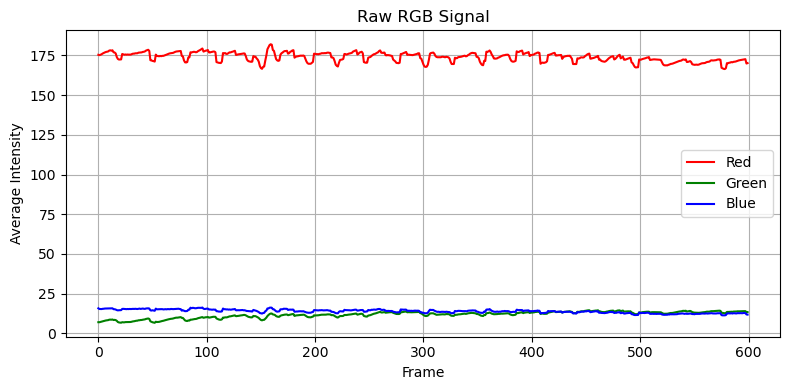

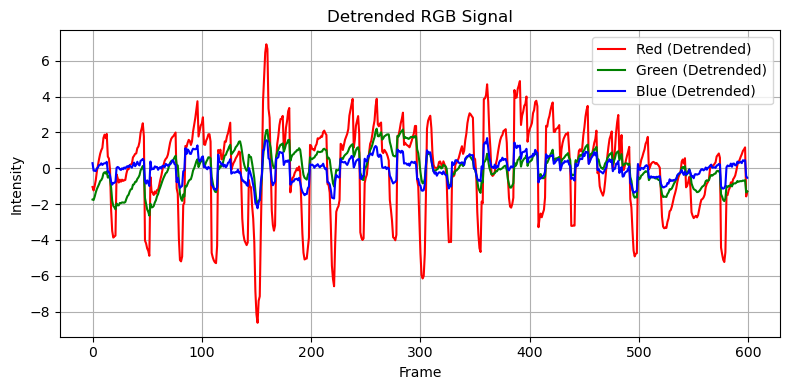

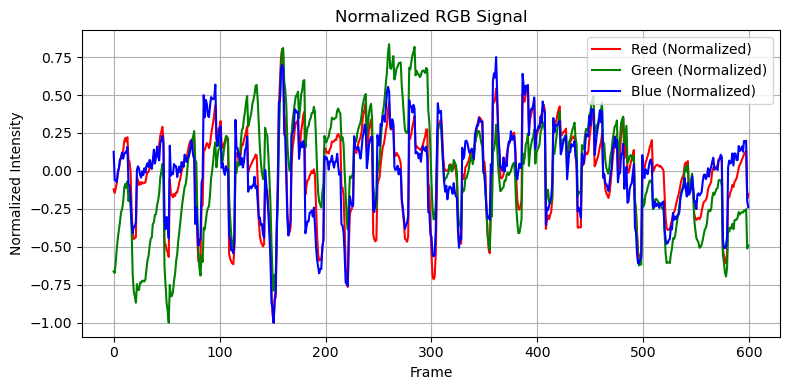

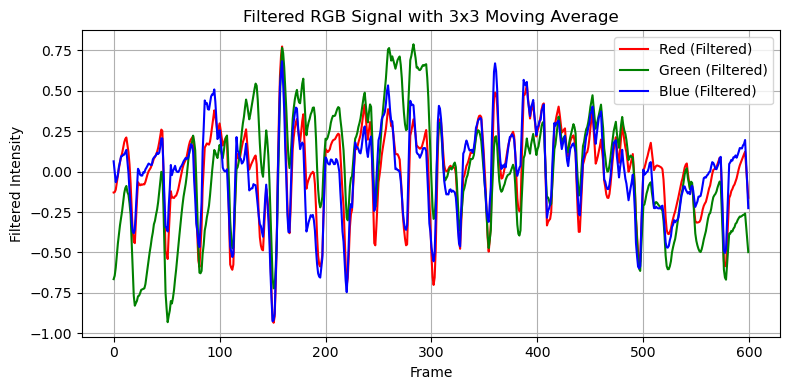

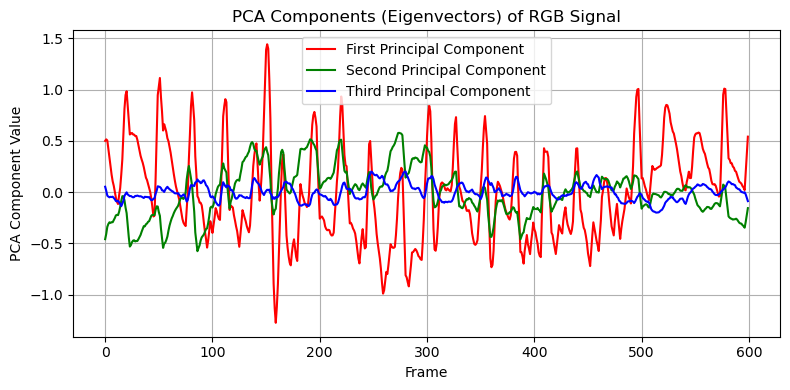

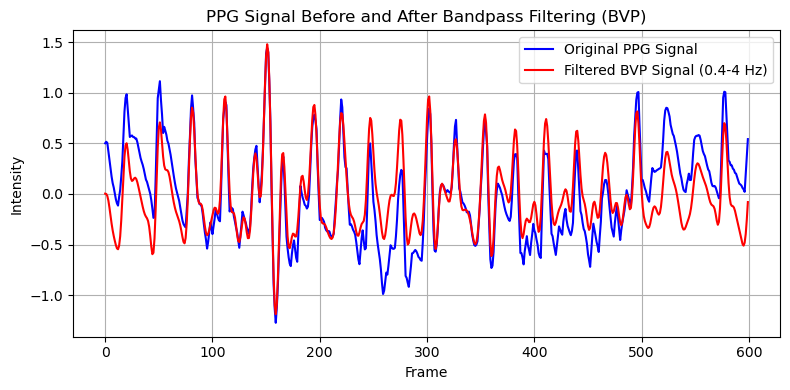

RGB signal shape: (600, 3)
First 5 rows (RGB values per frame):
 [[175.3624   7.0082  15.7386]
 [175.1603   6.9922  15.3166]
 [175.403    7.1933  15.3035]
 [175.7301   7.4385  15.2813]
 [176.2027   7.6379  15.4258]]
Filtered PPG signal shape: (600,)
First 5 rows of filtered PPG signal:
 [ 2.62940294e-03  5.57383528e-05 -1.99519378e-02 -6.62919665e-02
 -1.35670520e-01]


In [1]:
#12 signal processing backbone sample on one video to show how the signal are extracted from the video
import cv2
import numpy as np

def read_and_process_video(video_path, target_frames=600):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    rgb_array = []

    # Read and process up to 600 frames
    for i in range(min(total_frames, target_frames)):
        ret, frame = cap.read()
        if not ret:
            break

        # Resize for consistency (optional, can skip if full frame is used)
        frame = cv2.resize(frame, (100, 100))  # You can adjust size or remove this line

        # Convert BGR (OpenCV default) to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Compute average pixel intensity for R, G, B channels
        avg_rgb = np.mean(frame_rgb.reshape(-1, 3), axis=0)  # Shape: (3,)
        rgb_array.append(avg_rgb)

    cap.release()

    # If fewer than 600 frames, pad with zeros
    while len(rgb_array) < target_frames:
        rgb_array.append(np.zeros(3))

    # Convert to numpy array of shape (600, 3)
    rgb_array = np.array(rgb_array)
    return rgb_array
#*************************************************************************************************

import matplotlib.pyplot as plt

def extract_and_plot_rgb_signals(rgb_array):
    # Extract X(j) = (x1(j), ..., x600(j)) for j = 1, 2, 3
    red_signal = rgb_array[:, 0]
    green_signal = rgb_array[:, 1]
    blue_signal = rgb_array[:, 2]

    # Plotting the Raw RGB Signal
    plt.figure(figsize=(8, 4))
    plt.plot(red_signal, color='red', label='Red')
    plt.plot(green_signal, color='green', label='Green')
    plt.plot(blue_signal, color='blue', label='Blue')
    plt.title("Raw RGB Signal")
    plt.xlabel("Frame")
    plt.ylabel("Average Intensity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return red_signal, green_signal, blue_signal
#*****************************************************************************************************
from scipy.signal import detrend
import matplotlib.pyplot as plt

def apply_detrending_filter(red_signal, green_signal, blue_signal):
    # Apply scipy's detrend function
    red_detrended = detrend(red_signal, type='linear')
    green_detrended = detrend(green_signal, type='linear')
    blue_detrended = detrend(blue_signal, type='linear')

    # Plot the filtered signals
    plt.figure(figsize=(8, 4))
    plt.plot(red_detrended, color='red', label='Red (Detrended)')
    plt.plot(green_detrended, color='green', label='Green (Detrended)')
    plt.plot(blue_detrended, color='blue', label='Blue (Detrended)')
    plt.title("Detrended RGB Signal")
    plt.xlabel("Frame")
    plt.ylabel("Intensity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return red_detrended, green_detrended, blue_detrended

#****************************************************************************************************
# Step 4: Normalize the signals by dividing each by its maximum absolute value
def normalize_signal(red_signal, green_signal, blue_signal):
    red_normalized = red_signal / np.max(np.abs(red_signal))
    green_normalized = green_signal / np.max(np.abs(green_signal))
    blue_normalized = blue_signal / np.max(np.abs(blue_signal))

    # Plot the normalized signals
    plt.figure(figsize=(8, 4))
    plt.plot(red_normalized, color='red', label='Red (Normalized)')
    plt.plot(green_normalized, color='green', label='Green (Normalized)')
    plt.plot(blue_normalized, color='blue', label='Blue (Normalized)')
    plt.title("Normalized RGB Signal")
    plt.xlabel("Frame")
    plt.ylabel("Normalized Intensity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return red_normalized, green_normalized, blue_normalized
#*****************************************************************************************************
from scipy.ndimage import convolve1d

# Step 5: Apply a 3x3 kernel moving average filter
def apply_moving_average_filter(red_signal, green_signal, blue_signal):
    # Define the 3x3 kernel for moving average filter
    kernel = np.ones(3) / 3  # This is a 3-point moving average kernel

    # Apply the kernel to each signal using convolution
    red_filtered = convolve1d(red_signal, kernel, mode='nearest')
    green_filtered = convolve1d(green_signal, kernel, mode='nearest')
    blue_filtered = convolve1d(blue_signal, kernel, mode='nearest')

    # Plot the filtered signals
    plt.figure(figsize=(8, 4))
    plt.plot(red_filtered, color='red', label='Red (Filtered)')
    plt.plot(green_filtered, color='green', label='Green (Filtered)')
    plt.plot(blue_filtered, color='blue', label='Blue (Filtered)')
    plt.title("Filtered RGB Signal with 3x3 Moving Average")
    plt.xlabel("Frame")
    plt.ylabel("Filtered Intensity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return red_filtered, green_filtered, blue_filtered
#********************************************************************************************************
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Step 6: Apply PCA to recover independent source signals
def apply_pca_to_rgb(red_signal, green_signal, blue_signal, n_components=3):
    # Stack the RGB signals together to form a 2D matrix where each row is a frame and each column is a channel
    rgb_matrix = np.vstack([red_signal, green_signal, blue_signal]).T  # Shape: (frames, 3)

    # Apply PCA to the stacked RGB matrix
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(rgb_matrix)

    # Plot the first three principal components (eigenvectors)
    plt.figure(figsize=(8, 4))
    plt.plot(pca_components[:, 0], color='red', label='First Principal Component')
    plt.plot(pca_components[:, 1], color='green', label='Second Principal Component')
    plt.plot(pca_components[:, 2], color='blue', label='Third Principal Component')
    plt.title("PCA Components (Eigenvectors) of RGB Signal")
    plt.xlabel("Frame")
    plt.ylabel("PCA Component Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pca_components
#********************************************************************************************************
from scipy.signal import butter, filtfilt
import numpy as np

# Step 7: Apply bandpass filter to the PPG signal (first eigenvector)
def bandpass_filter(signal, lowcut=0.4, highcut=4.0, fs=30.0, order=4):
    # Create the bandpass filter
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist

    # Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply the filter to the signal using filtfilt (zero-phase filtering)
    filtered_signal = filtfilt(b, a, signal)
    
    return filtered_signal

# Step 8: Apply PCA and select the first eigenvector (PPG signal)
def extract_ppg_signal(r_filtered, g_filtered, b_filtered):
    # Stack the signals together to apply PCA
    rgb_matrix = np.vstack([r_filtered, g_filtered, b_filtered]).T  # Shape: (frames, 3)
    
    # Apply PCA to the stacked RGB matrix
    pca = PCA(n_components=3)
    pca_components = pca.fit_transform(rgb_matrix)

    # The first eigenvector (principal component) is the PPG signal
    ppg_signal = pca_components[:, 0]

    # Apply bandpass filter to the PPG signal
    filtered_ppg_signal = bandpass_filter(ppg_signal, lowcut=0.4, highcut=4.0, fs=30.0)

    # Plot the original and filtered PPG signals
    plt.figure(figsize=(8, 4))
    plt.plot(ppg_signal, label='Original PPG Signal', color='blue')
    plt.plot(filtered_ppg_signal, label='Filtered PPG Signal (0.4-4 Hz)', color='red')
    plt.title("PPG Signal Before and After Bandpass Filtering")
    plt.xlabel("Frame")
    plt.ylabel("Intensity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return filtered_ppg_signal
#****************************************************************************************************
def extract_ppg_signal(r_filtered, g_filtered, b_filtered):
    # Stack the signals together to apply PCA
    rgb_matrix = np.vstack([r_filtered, g_filtered, b_filtered]).T  # Shape: (frames, 3)
    
    # Apply PCA to the stacked RGB matrix
    pca = PCA(n_components=3)
    pca_components = pca.fit_transform(rgb_matrix)

    # The first eigenvector (principal component) is the PPG signal
    ppg_signal = pca_components[:, 0]

    # Apply bandpass filter to the PPG signal to get the BVP signal
    bvp_signal = bandpass_filter(ppg_signal, lowcut=0.4, highcut=4.0, fs=30.0)

    # Plot the original and filtered PPG (BVP) signals
    plt.figure(figsize=(8, 4))
    plt.plot(ppg_signal, label='Original PPG Signal', color='blue')
    plt.plot(bvp_signal, label='Filtered BVP Signal (0.4-4 Hz)', color='red')
    plt.title("PPG Signal Before and After Bandpass Filtering (BVP)")
    plt.xlabel("Frame")
    plt.ylabel("Intensity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return bvp_signal

# ---- Example usage ----
video_path = "C:/Users/hp/Desktop/DatasetVideoFiles/DatasetVideoFiles/sample1.mp4"
rgb_signal = read_and_process_video(video_path)  # Step 1
r, g, b = extract_and_plot_rgb_signals(rgb_signal)  # Step 2
r_d, g_d, b_d = apply_detrending_filter(r, g, b)  # Step 3
r_norm, g_norm, b_norm = normalize_signal(r_d, g_d, b_d)  # Step 4
r_filtered, g_filtered, b_filtered = apply_moving_average_filter(r_norm, g_norm, b_norm)  # Step 5
pca_components = apply_pca_to_rgb(r_filtered, g_filtered, b_filtered)  # Step 6
filtered_ppg_signal = extract_ppg_signal(r_filtered, g_filtered, b_filtered)# Step 7

print("RGB signal shape:", rgb_signal.shape)  # Should print (600, 3)
print("First 5 rows (RGB values per frame):\n", rgb_signal[:5])

print("Filtered PPG signal shape:", filtered_ppg_signal.shape)
print("First 5 rows of filtered PPG signal:\n", filtered_ppg_signal[:5])






